In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import seaborn as sns

In [4]:
# 1. Load dữ liệu đã làm sạch từ bước trước
df = pd.read_csv('training_data_final.csv', parse_dates=['Datetime'], index_col='Datetime')


In [16]:
# 2. FEATURE ENGINEERING (Tạo đặc trưng nâng cao)
# XGBoost thích nhiều dữ liệu đầu vào để học luật

features = ['Gold', 'Silver', 'Brent', 'Wheat', 'USD index']
target = 'Gold'

# A. Tạo Lag (Dữ liệu quá khứ t-1, t-2)
for col in features:
    df[f'{col}_lag1'] = df[col].shift(1) # Giá 30s trước
    df[f'{col}_lag2'] = df[col].shift(2) # Giá 60s

# B. Tạo Rolling Features (Xu hướng ngắn hạn)
# Trung bình giá Vàng trong 90s qua
df['Gold_MA5'] = df['Gold'].rolling(window=5).mean().shift(1)
# Độ biến động (Standard Deviation) của Vàng trong 150s qua
df['Gold_Vol5'] = df['Gold'].rolling(window=5).std().shift(1)
# C. Xóa các dòng NaN do shift/rolling tạo ra
df.dropna(inplace=True)

In [6]:
# 3. Chuẩn bị dữ liệu Train/Test
# Input: Lấy tất cả các cột Lag và Rolling, TRỪ cột giá hiện tại
input_cols = [c for c in df.columns if 'lag' in c or 'MA' in c or 'Vol' in c]
X = df[input_cols]
y = df[target]

# Chia theo thời gian (Không random shuffle)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [7]:
# 4. KHỞI TẠO & TRAIN XGBOOST
# Các tham số cơ bản:
# - n_estimators: Số lượng cây (1000 cây)
# - learning_rate: Tốc độ học (0.01 là học chậm mà chắc)
# - max_depth: Độ sâu của cây (tránh Overfitting)
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50, # Dừng nếu không cải thiện sau 50 vòng
    random_state=42
)

# Train mô hình (cần tập eval để early stopping)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [8]:
# 5. DỰ ĐOÁN & ĐÁNH GIÁ
predictions = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f"✅ Sai số trung bình (MAE): {mae:.2f}") 
print(f"✅ Sai số toàn phương (RMSE): {rmse:.2f}")


✅ Sai số trung bình (MAE): 0.02
✅ Sai số toàn phương (RMSE): 0.02


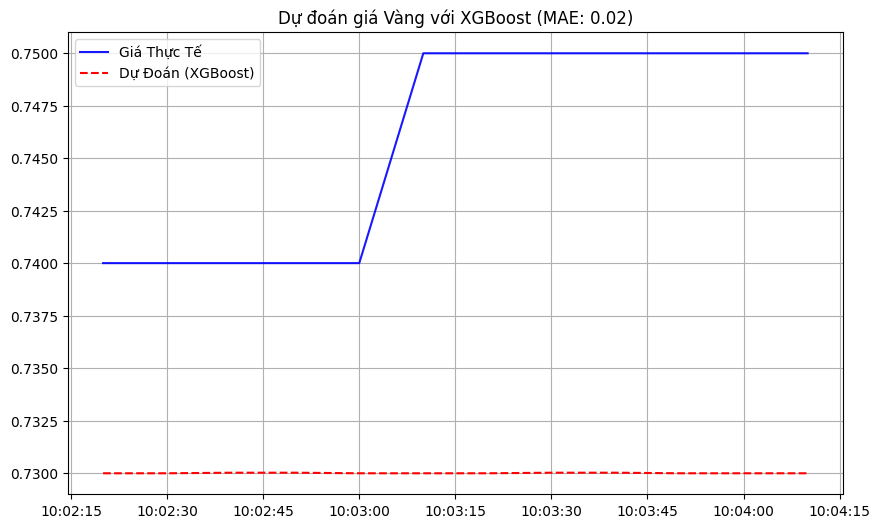

In [12]:
# 6. VẼ BIỂU ĐỒ SO SÁNH
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Giá Thực Tế', color='blue', alpha=0.9)
plt.plot(y_test.index, predictions, label='Dự Đoán (XGBoost)', color='red', linestyle='--')
plt.title(f'Dự đoán giá Vàng với XGBoost (MAE: {mae:.2f})')
plt.legend()
plt.grid(True)
plt.show()

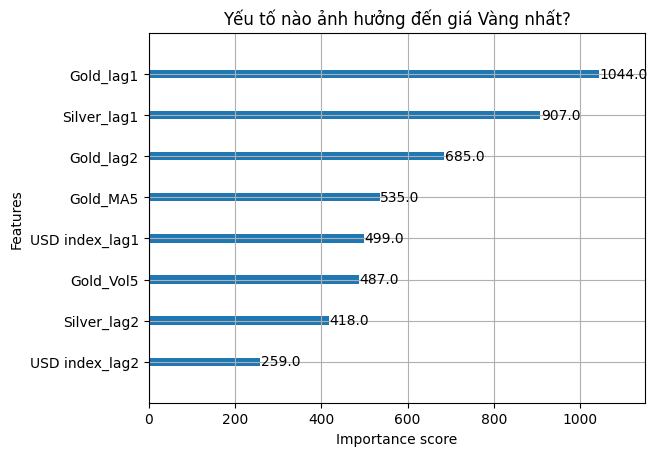

In [13]:
# 7. (QUAN TRỌNG) XEM YẾU TỐ NÀO ẢNH HƯỞNG NHẤT?
# XGBoost cho phép xem Feature Importance
xgb.plot_importance(model, max_num_features=10)
plt.title("Yếu tố nào ảnh hưởng đến giá Vàng nhất?")
plt.show()